In [1]:
from pandas import MultiIndex, Int16Dtype
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
sns.set_style('darkgrid')

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge,LinearRegression, LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [2]:
datos = pd.read_csv("../../data/DataFrame_Final_Cierre_Cluster.csv",parse_dates=['FECHA'])

In [3]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117155 entries, 0 to 2117154
Data columns (total 24 columns):
 #   Column               Dtype         
---  ------               -----         
 0   ESTACION             int64         
 1   ANIO                 int64         
 2   MES                  int64         
 3   DIA                  int64         
 4   HORA                 int64         
 5   FECHA                datetime64[ns]
 6   DIA_SEMANA           int64         
 7   AM_PM                object        
 8   TEMPORADA            object        
 9   TEMPORADA_NUM        int64         
 10  Es_Festivo           int64         
 11  Es_FinSemana         int64         
 12  TEMPERATURA          float64       
 13  VIENTO               float64       
 14  PRESION              int64         
 15  HUMEDAD              int64         
 16  PRECIPITACION_1h     float64       
 17  PRECIPITACION_3h     float64       
 18  DESC_TIEMPO          object        
 19  DESC_TIEMPO_detalle  

### Preparación datos

In [4]:

bicimad_def = datos.groupby(['ESTACION','ANIO','MES','DIA','TEMPORADA','DIA_SEMANA', 'Es_Festivo', 'Es_FinSemana'
                          ]).agg(DEMANDA=('DEMANDA', 'sum'),
                                 TEMP_MAX= ('TEMPERATURA','max'),
                                 TEMP_MIN = ('TEMPERATURA','min'),
                                 HUMEDAD = ('HUMEDAD','mean'),
                                 VIENTO = ('VIENTO','mean'),
                                 PRESION = ('PRESION', 'mean'),
                                 PRECIPITACION_1h = ('PRECIPITACION_1h', 'mean'),
                                 PRECIPITACION_3h = ('PRECIPITACION_3h', 'mean'),
                                 DESC_TIEMPO = ('DESC_TIEMPO', lambda x: x.value_counts().index[0]))
bicimad_def = bicimad_def.reset_index()


In [5]:
bicimad_def

,ESTACION,ANIO,MES,DIA,TEMPORADA,DIA_SEMANA,Es_Festivo,Es_FinSemana,DEMANDA,TEMP_MAX,TEMP_MIN,HUMEDAD,VIENTO,PRESION,PRECIPITACION_1h,PRECIPITACION_3h,DESC_TIEMPO
0,1,2018,1,1,INVIERNO,2,1,0,39,10.98,2.67,69.818182,7.080909,1030.727273,0.000000,0.000,Clouds
1,1,2018,1,2,INVIERNO,3,0,0,75,12.69,7.24,73.210526,5.420000,1031.842105,0.000000,0.000,Clouds
2,1,2018,1,3,INVIERNO,4,0,0,68,13.58,8.13,90.176471,4.794118,1031.588235,0.000000,0.000,Clouds
3,1,2018,1,4,INVIERNO,5,0,0,77,13.99,8.28,84.105263,5.334211,1025.789474,0.000000,0.000,Clouds
4,1,2018,1,5,INVIERNO,6,0,0,55,10.88,8.46,84.363636,5.445000,1012.045455,0.198636,0.075,Clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129326,175,2020,2,25,INVIERNO,3,0,0,87,17.48,5.91,54.769231,6.007692,1018.307692,0.000000,0.000,Clouds
129327,175,2020,2,26,INVIERNO,4,0,0,158,15.18,6.22,48.600000,5.321000,1020.500000,0.000000,0.000,Clear
129328,175,2020,2,27,INVIERNO,5,0,0,173,18.41,6.35,49.095238,6.207143,1020.619048,0.000000,0.000,Clear
129329,175,2020,2,28,INVIERNO,6,0,0,166,18.38,5.74,49.428571,2.174762,1019.571429,0.000000,0.000,Clear


In [301]:
#cat_cols= ['ANIO', 'MES', 'DIA_SEMANA', 'TEMPORADA','DESC_TIEMPO','AM_PM', 'Es_Festivo', 'Es_FinSemana']
cat_cols= ['MES', 'DIA_SEMANA', 'TEMPORADA', 'Es_Festivo', 'Es_FinSemana','DESC_TIEMPO']
#cat_cols= ['MES', 'DIA_SEMANA','Es_Festivo', 'Es_FinSemana']

num_cols= ['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION']

In [302]:
bicimad = bicimad_def

#bicimad = datos.drop(['CLUSTER_FullCols','TEMPORADA_NUM','CLUSTER_soloDemanda','CLUSTER_soloGeo','DIA','ANIO','DESC_TIEMPO_detalle'], axis=1)


bicimad['FECHA'] =pd.to_datetime({'year': bicimad['ANIO'],
                                          'month': bicimad["MES"]
                                          ,'day':  bicimad['DIA']
                                          },
                                          format='%d-%m-%Y', errors='coerce')

bicimad['MES']   = bicimad['MES'].astype('category')
bicimad['DIA_SEMANA'] = bicimad['DIA_SEMANA'].astype('category')
bicimad['Es_Festivo'] = bicimad['Es_Festivo'].astype('category')
bicimad['Es_FinSemana'] = bicimad['Es_FinSemana'].astype('category')
bicimad['DESC_TIEMPO'] = bicimad['DESC_TIEMPO'].astype('category')

bicimad = pd.get_dummies(bicimad, columns=cat_cols, drop_first=True)

X = bicimad[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION','PRECIPITACION_1h','PRECIPITACION_3h']]

scaler = StandardScaler()
bicimad[['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION','PRECIPITACION_1h','PRECIPITACION_3h']] = scaler.fit_transform(X)

bicimad = bicimad.drop(['ANIO','DIA'], axis=1)

bicimad

,ESTACION,DEMANDA,TEMP_MAX,TEMP_MIN,HUMEDAD,VIENTO,PRESION,PRECIPITACION_1h,PRECIPITACION_3h,FECHA,...,TEMPORADA_VERANO,Es_Festivo_1,Es_FinSemana_1,DESC_TIEMPO_Clouds,DESC_TIEMPO_Drizzle,DESC_TIEMPO_Fog,DESC_TIEMPO_Mist,DESC_TIEMPO_Rain,DESC_TIEMPO_Snow,DESC_TIEMPO_Thunderstorm
0,1,39,-1.026930,-1.067735,0.725362,1.669834,1.987357,-0.250454,-0.203229,2018-01-01,...,0,1,0,1,0,0,0,0,0,0
1,1,75,-0.832167,-0.403777,0.907454,0.805625,2.143212,-0.250454,-0.203229,2018-01-02,...,0,0,0,1,0,0,0,0,0,0
2,1,68,-0.730798,-0.274473,1.818144,0.479964,2.107721,-0.250454,-0.203229,2018-01-03,...,0,0,0,1,0,0,0,0,0,0
3,1,77,-0.684101,-0.252680,1.492257,0.760986,1.297043,-0.250454,-0.203229,2018-01-04,...,0,0,0,1,0,0,0,0,0,0
4,1,55,-1.038320,-0.226529,1.506126,0.818633,-0.624397,1.093123,0.580350,2018-01-05,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129326,175,87,-0.286600,-0.597008,-0.082428,1.111414,0.251076,-0.250454,-0.203229,2020-02-25,...,0,0,0,1,0,0,0,0,0,0
129327,175,158,-0.548563,-0.551969,-0.413577,0.754113,0.557564,-0.250454,-0.203229,2020-02-26,...,0,0,0,0,0,0,0,0,0,0
129328,175,173,-0.180676,-0.533082,-0.386994,1.215193,0.574207,-0.250454,-0.203229,2020-02-27,...,0,0,0,0,0,0,0,0,0,0
129329,175,166,-0.184093,-0.621707,-0.369102,-0.882947,0.427748,-0.250454,-0.203229,2020-02-28,...,0,0,0,0,0,0,0,0,0,0


In [34]:
bicimad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129331 entries, 0 to 129330
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ESTACION                  129331 non-null  int64         
 1   ANIO                      129331 non-null  int64         
 2   DIA                       129331 non-null  int64         
 3   DEMANDA                   129331 non-null  int64         
 4   TEMP_MAX                  129331 non-null  float64       
 5   TEMP_MIN                  129331 non-null  float64       
 6   HUMEDAD                   129331 non-null  float64       
 7   VIENTO                    129331 non-null  float64       
 8   PRESION                   129331 non-null  float64       
 9   PRECIPITACION_1h          129331 non-null  float64       
 10  PRECIPITACION_3h          129331 non-null  float64       
 11  FECHA                     129331 non-null  datetime64[ns]
 12  ME

In [9]:
seed = 99

models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed)))
models.append(('GBR', GradientBoostingRegressor(random_state=seed)))
models.append(('LGBMR', LGBMRegressor(random_state=seed)))
models.append(('XGBR', XGBRegressor(random_state=seed)))

In [14]:
Estaciones = [145,58,148,157,163]

# Cluster 0 -> 145
# Cluster 1 -> 58
# Cluster 2 -> 148
# Cluster 3 -> 157
# Cluster 4 -> 163

In [84]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid_RF = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3,5,7],
    'min_samples_leaf': [1,2,3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,500,1000]
}

param_grid_GB = {'learning_rate': [0.01,0.02,0.04, 0.1],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
               'max_depth'    : [80, 90, 100,110]
                 }

param_grid_LGBM = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt', 'dart'],
    'objective' : ['binary'],
    'max_bin':[255, 510],
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

param_grid_XGB = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [80, 90, 100,110]
        }

## Tuneado modelo Random Forest

In [91]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print()
    
    # Create a based model
    rf = RandomForestRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid_RF, cv = 2, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Estacion: 145

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1000}
Estacion: 58

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}
Estacion: 148

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100}
Estacion: 157

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100}
Estacion: 163

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
{'bootstrap': True, 'max_depth': 80, 'max_features': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n

## Tuneado modelo Gradient Boosting

In [ ]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print()
    
    # Create a based model
    GB = RandomForestRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = GBR, param_grid = param_grid_GB, cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

## Tuneado modelo LBGM

In [92]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print()
    
    # Create a based model
    LGBM = LGBMRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = LGBM, param_grid = param_grid_LGBM, cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

Estacion: 145

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.005, 'max_bin': 255, 'n_estimators': 8, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
Estacion: 58

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.005, 'max_bin': 255, 'n_estimators': 8, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
Estacion: 148

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.005, 'max_bin': 255, 'n_estimators': 8, 'num_leaves': 6, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
Estacion: 157

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
{'boosti

## Tuneado XGBoost

In [ ]:
for i in Estaciones:
    
    bicimad_est = bicimad[bicimad['ESTACION'] == i]
    
    X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
    y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
    y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']
    
    print(f'Estacion: {i}')
    print()
    
    # Create a based model
    XGB = XGBRegressor(random_state=seed)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = XGB, param_grid = param_grid_XGB, cv = 3, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

# Comparación de Modelos

### Cluster 0

In [340]:
bicimad_est = bicimad[bicimad['ESTACION'] == 145]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2020-02-15 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-02-16 00:00:00')]['DEMANDA']


models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed,
                                           bootstrap= True, 
                                           max_depth= 80, 
                                           max_features= 7, 
                                           min_samples_leaf= 1, 
                                           min_samples_split= 8, 
                                           n_estimators= 500)))

models.append(('GBR', GradientBoostingRegressor(random_state=seed,
                                               learning_rate= 0.02, 
                                                max_depth= 80, 
                                                n_estimators= 100, 
                                                subsample= 0.2)))

models.append(('LGBMR', LGBMRegressor(random_state=seed,
                                     learning_rate = 0.1,
                                      num_leaves= 6,
                                      max_depth= 80,
                                      n_estimators= 500)))

models.append(('XGBR', XGBRegressor(random_state=seed,
                                    colsample_bytree= 1.0, 
                                    gamma= 5, 
                                    max_depth= 80, 
                                    min_child_weight= 1, 
                                    subsample= 0.8)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print()

Model: RFR 
R^2: 0.85.
MSE: 136.74
RMSE: 11.69

Model: GBR 
R^2: 0.78.
MSE: 119.13
RMSE: 10.91

Model: LGBMR 
R^2: 0.91.
MSE: 128.99
RMSE: 11.36

Model: XGBR 
R^2: 1.00.
MSE: 98.06
RMSE: 9.90



0.6428490617608564


,Importance
TEMP_MAX,87
HUMEDAD,72
VIENTO,59
PRESION,55
TEMP_MIN,54
Es_FinSemana_1,27
Es_Festivo_1,22
PRECIPITACION_1h,21
MES_8,20
MES_3,16


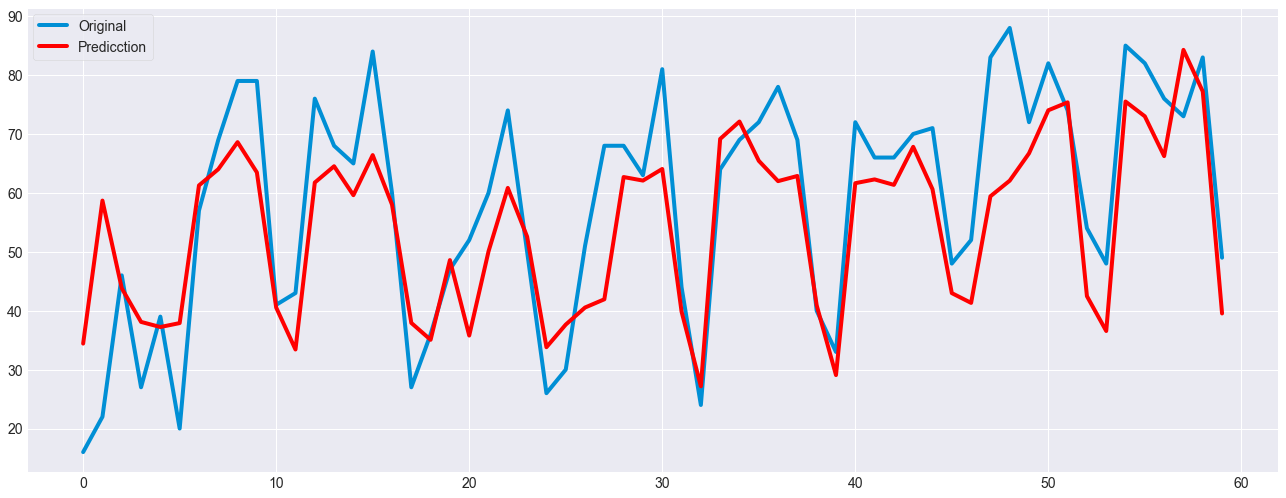

In [341]:
bicimad_est = bicimad[bicimad['ESTACION'] == 145]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']


model = LGBMRegressor(random_state=seed,
                                     learning_rate = 0.1,
                                      num_leaves= 9,
                                      max_depth= 200,
                                      n_estimators= 70)

resultado = model.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model.score(X_test, y_test, sample_weight=None)


print(score)
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances[:30]


In [267]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True
            )

cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_score,train_score
0,0.056340,0.002744,0.554201,0.815358
1,0.017176,0.002673,0.591616,0.798458
2,0.018807,0.002926,0.502515,0.822630
3,0.017797,0.002693,0.556221,0.814503
4,0.017308,0.002753,0.610132,0.787367
5,0.017268,0.002590,0.605824,0.800041
6,0.017621,0.002766,0.482397,0.795924
7,0.017532,0.002633,0.626945,0.787208
8,0.021315,0.002708,0.565399,0.801891
9,0.018241,0.002667,0.660514,0.790958


## Cluster 1

In [268]:
bicimad_est = bicimad[bicimad['ESTACION'] == 58]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed,
                                           bootstrap= True, 
                                           max_depth= 80, 
                                           max_features= 7, 
                                           min_samples_leaf= 2, 
                                           min_samples_split= 8, 
                                           n_estimators= 1000)))

models.append(('GBR', GradientBoostingRegressor(random_state=seed,
                                               learning_rate= 0.02, 
                                                max_depth= 80, 
                                                n_estimators= 100, 
                                                subsample= 0.2)))

models.append(('LGBMR', LGBMRegressor(random_state=seed,
                                      learning_rate = 0.1,
                                      num_leaves= 6,
                                      max_depth= 80,
                                      n_estimators= 1000)))

models.append(('XGBR', XGBRegressor(random_state=seed,
                                    colsample_bytree= 1.0, 
                                    gamma= 5, 
                                    max_depth= 80, 
                                    min_child_weight= 1, 
                                    subsample= 0.8)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print()

Model: RFR 
R^2: 0.81.
MSE: 298.07
RMSE: 17.26

Model: GBR 
R^2: 0.78.
MSE: 314.18
RMSE: 17.73

Model: LGBMR 
R^2: 0.96.
MSE: 416.68
RMSE: 20.41

Model: XGBR 
R^2: 1.00.
MSE: 330.34
RMSE: 18.18



0.37342136335710696


,Importance
TEMP_MAX,127
HUMEDAD,113
TEMP_MIN,109
VIENTO,89
PRESION,63
Es_FinSemana_1,30
PRECIPITACION_1h,27
Es_Festivo_1,23
MES_6,22
MES_8,20


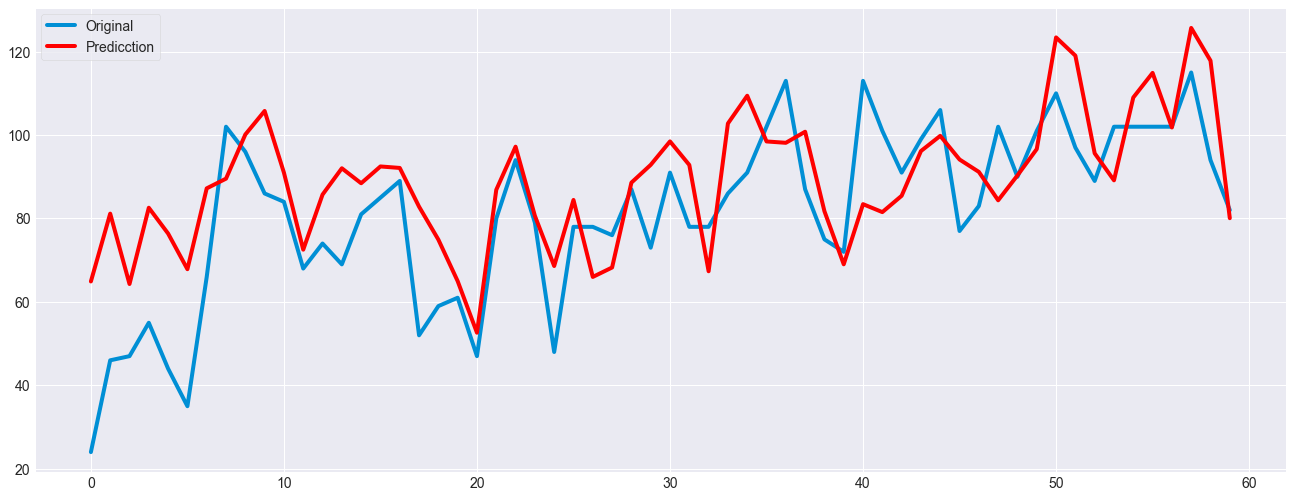

In [325]:
bicimad_est = bicimad[bicimad['ESTACION'] == 58]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']


model = LGBMRegressor(random_state=seed,
                                     learning_rate = 0.09,
                                      num_leaves= 5,
                                      max_depth= 100,
                                      n_estimators= 200)

resultado = model.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model.score(X_test, y_test, sample_weight=None)


print(score)
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances[:30]


In [326]:

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123567)
cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True
            )

cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_score,train_score
0,0.050503,0.003557,0.527508,0.813916
1,0.025474,0.003067,0.557645,0.809058
2,0.026582,0.003349,0.577680,0.806757
3,0.024925,0.003076,0.593438,0.799325
4,0.025449,0.003171,0.528062,0.806038
5,0.027662,0.003053,0.551549,0.805770
6,0.025472,0.003017,0.573405,0.806374
7,0.027083,0.003113,0.522831,0.804912
8,0.027115,0.003112,0.503302,0.812977
9,0.025615,0.003087,0.558984,0.808522


## Cluster 2

In [342]:
bicimad_est = bicimad[bicimad['ESTACION'] == 148]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed,
                                           bootstrap= True, 
                                           max_depth= 80, 
                                           max_features= 7, 
                                           min_samples_leaf= 2, 
                                           min_samples_split= 12, 
                                           n_estimators= 500)))

models.append(('GBR', GradientBoostingRegressor(random_state=seed,
                                               learning_rate= 0.02, 
                                                max_depth= 80, 
                                                n_estimators= 100, 
                                                subsample= 0.5)))

models.append(('LGBMR', LGBMRegressor(random_state=seed,
                                      learning_rate = 0.1,
                                      num_leaves= 6,
                                      max_depth= 80,
                                      n_estimators= 500)))

models.append(('XGBR', XGBRegressor(random_state=seed,
                                    colsample_bytree= 0.8, 
                                    gamma= 1.5, 
                                    max_depth= 80, 
                                    min_child_weight= 5, 
                                    subsample= 1)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print()

Model: RFR 
R^2: 0.78.
MSE: 68.99
RMSE: 8.31

Model: GBR 
R^2: 0.93.
MSE: 77.44
RMSE: 8.80

Model: LGBMR 
R^2: 0.92.
MSE: 71.09
RMSE: 8.43

Model: XGBR 
R^2: 1.00.
MSE: 79.72
RMSE: 8.93



0.6769141922771753


,Importance
Es_FinSemana_1,0.168523
TEMP_MAX,0.154824
PRESION,0.127848
HUMEDAD,0.115108
VIENTO,0.097245
TEMP_MIN,0.083183
MES_6,0.047232
MES_8,0.037180
Es_Festivo_1,0.035880
PRECIPITACION_1h,0.029475


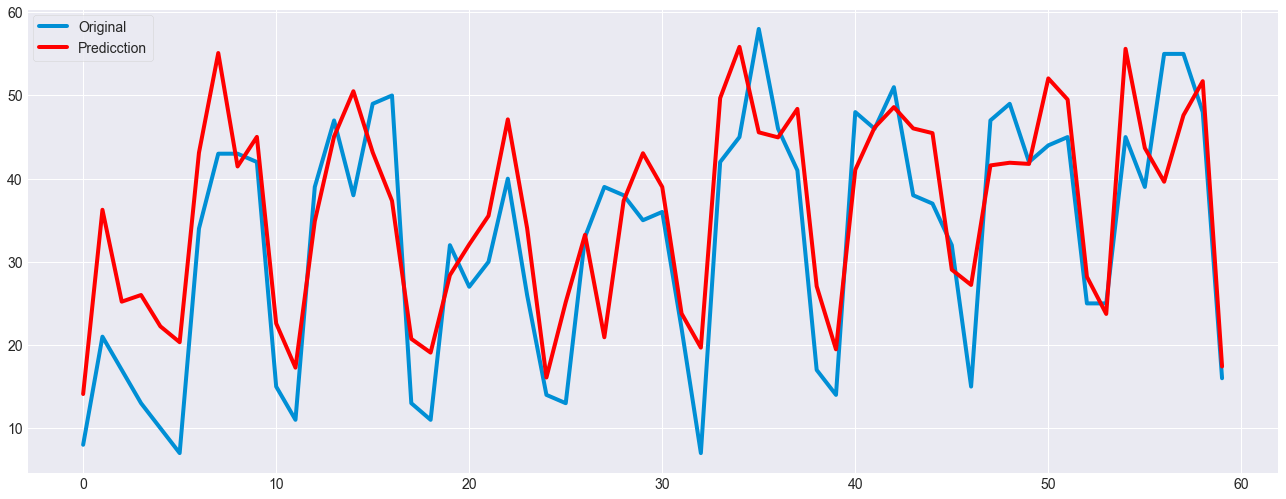

In [359]:
bicimad_est = bicimad[bicimad['ESTACION'] == 148]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']


model = GradientBoostingRegressor(random_state=seed,
                                  learning_rate= 0.05, 
                                  max_depth= 100, 
                                  n_estimators= 200, 
                                  subsample= 0.4)

resultado = model.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model.score(X_test, y_test, sample_weight=None)


print(score)
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances[:30]

In [344]:

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123567)
cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True
            )

cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_score,train_score
0,0.175550,0.004226,0.608836,0.930586
1,0.172777,0.004342,0.581812,0.926253
2,0.168577,0.004256,0.564154,0.931432
3,0.165422,0.004111,0.557747,0.933576
4,0.164013,0.004184,0.549862,0.929803
5,0.167445,0.004169,0.598436,0.931731
6,0.169706,0.004546,0.674366,0.928230
7,0.168423,0.004316,0.630966,0.917732
8,0.163050,0.004115,0.495071,0.941557
9,0.164932,0.004011,0.543323,0.936576


## Cluster 3

In [360]:
bicimad_est = bicimad[bicimad['ESTACION'] == 157]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed,
                                           bootstrap= True, 
                                           max_depth= 80, 
                                           max_features= 7, 
                                           min_samples_leaf= 2, 
                                           min_samples_split= 10, 
                                           n_estimators= 500)))

models.append(('GBR', GradientBoostingRegressor(random_state=seed,
                                               learning_rate= 0.02, 
                                                max_depth= 80, 
                                                n_estimators= 100, 
                                                subsample= 0.5)))

models.append(('LGBMR', LGBMRegressor(random_state=seed,
                                      learning_rate = 0.1,
                                      num_leaves= 6,
                                      max_depth= 80,
                                      n_estimators= 500)))

models.append(('XGBR', XGBRegressor(random_state=seed,
                                    colsample_bytree= 0.8, 
                                    gamma= 1.5, 
                                    max_depth= 80, 
                                    min_child_weight= 5, 
                                    subsample= 1)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print()

Model: RFR 
R^2: 0.80.
MSE: 635.54
RMSE: 25.21

Model: GBR 
R^2: 0.94.
MSE: 610.99
RMSE: 24.72

Model: LGBMR 
R^2: 0.93.
MSE: 881.33
RMSE: 29.69

Model: XGBR 
R^2: 1.00.
MSE: 797.33
RMSE: 28.24



0.41750784320669376


,Importance
TEMP_MAX,0.209301
Es_FinSemana_1,0.174099
HUMEDAD,0.107206
PRESION,0.105652
TEMP_MIN,0.087097
VIENTO,0.082499
Es_Festivo_1,0.033568
MES_8,0.029126
PRECIPITACION_1h,0.021566
MES_6,0.017684


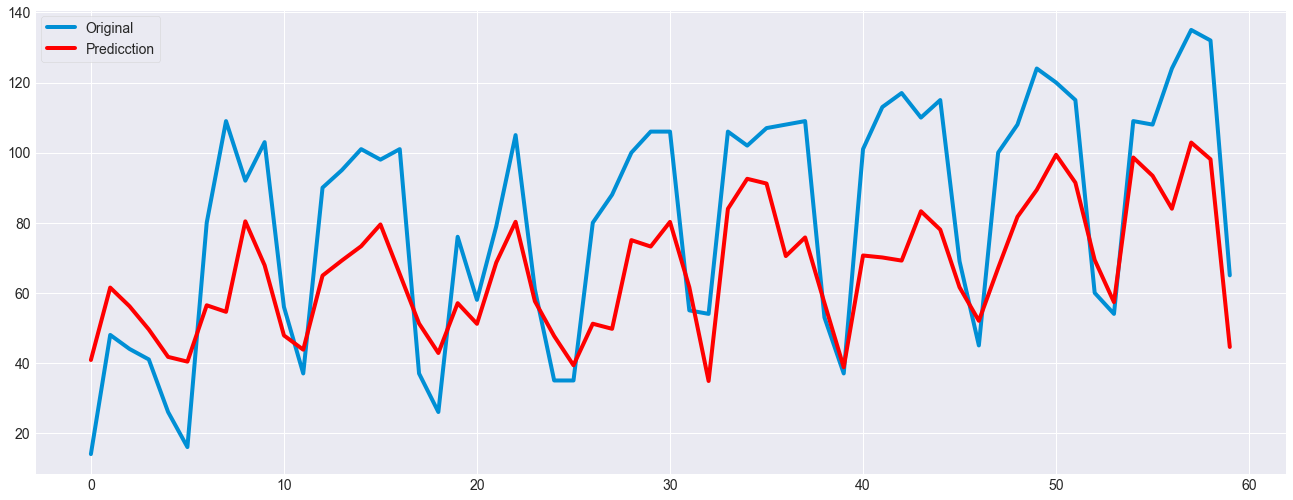

In [395]:
bicimad_est = bicimad[bicimad['ESTACION'] == 157]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']


model = GradientBoostingRegressor(random_state=seed,
                                  learning_rate= 0.02, 
                                  max_depth= 80, 
                                  n_estimators= 100, 
                                  subsample= 0.5)

resultado = model.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model.score(X_test, y_test, sample_weight=None)


print(score)
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances[:30]

In [393]:

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123567)
cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True
            )

cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_score,train_score
0,1.047596,0.074234,0.646032,0.749961
1,1.036001,0.074599,0.551953,0.775068
2,1.040273,0.074556,0.570390,0.763803
3,1.031686,0.074233,0.536225,0.765249
4,1.028183,0.074016,0.574287,0.776742
5,1.031107,0.074153,0.626227,0.760061
6,1.029954,0.074400,0.618532,0.753892
7,1.029687,0.073958,0.675967,0.743180
8,1.031066,0.073977,0.521870,0.789566
9,1.032049,0.074035,0.621454,0.758529


## Cluster 4

In [394]:
bicimad_est = bicimad[bicimad['ESTACION'] == 163]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']
    

models = list()
models.append(('RFR', RandomForestRegressor(random_state=seed,
                                           bootstrap= True, 
                                           max_depth= 80, 
                                           max_features= 7, 
                                           min_samples_leaf= 2, 
                                           min_samples_split= 10, 
                                           n_estimators= 500)))

models.append(('GBR', GradientBoostingRegressor(random_state=seed,
                                               learning_rate= 0.02, 
                                                max_depth= 80, 
                                                n_estimators= 100, 
                                                subsample= 0.5)))

models.append(('LGBMR', LGBMRegressor(random_state=seed,
                                      learning_rate = 0.1,
                                      num_leaves= 6,
                                      max_depth= 80,
                                      n_estimators= 500)))

models.append(('XGBR', XGBRegressor(random_state=seed,
                                    colsample_bytree= 0.8, 
                                    gamma= 1.5, 
                                    max_depth= 80, 
                                    min_child_weight= 5, 
                                    subsample= 1)))
    
for name, model in models:
    resultado = model.fit(X_train, y_train)
    score = model.score(X_train, y_train, sample_weight=None)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(0.5)
    print(f'Model: {name} ') 
    print('R^2: {:0.2f}.'.format(score))
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % rmse)
    print()

Model: RFR 
R^2: 0.82.
MSE: 684.96
RMSE: 26.17

Model: GBR 
R^2: 0.94.
MSE: 782.64
RMSE: 27.98

Model: LGBMR 
R^2: 0.93.
MSE: 690.37
RMSE: 26.27

Model: XGBR 
R^2: 1.00.
MSE: 834.29
RMSE: 28.88



0.05562324639066896


,Importance
HUMEDAD,0.195726
TEMP_MIN,0.147003
VIENTO,0.116527
PRESION,0.112041
TEMP_MAX,0.109348
MES_6,0.058717
Es_FinSemana_1,0.032693
Es_Festivo_1,0.019079
PRECIPITACION_1h,0.017409
DIA_SEMANA_6,0.016044


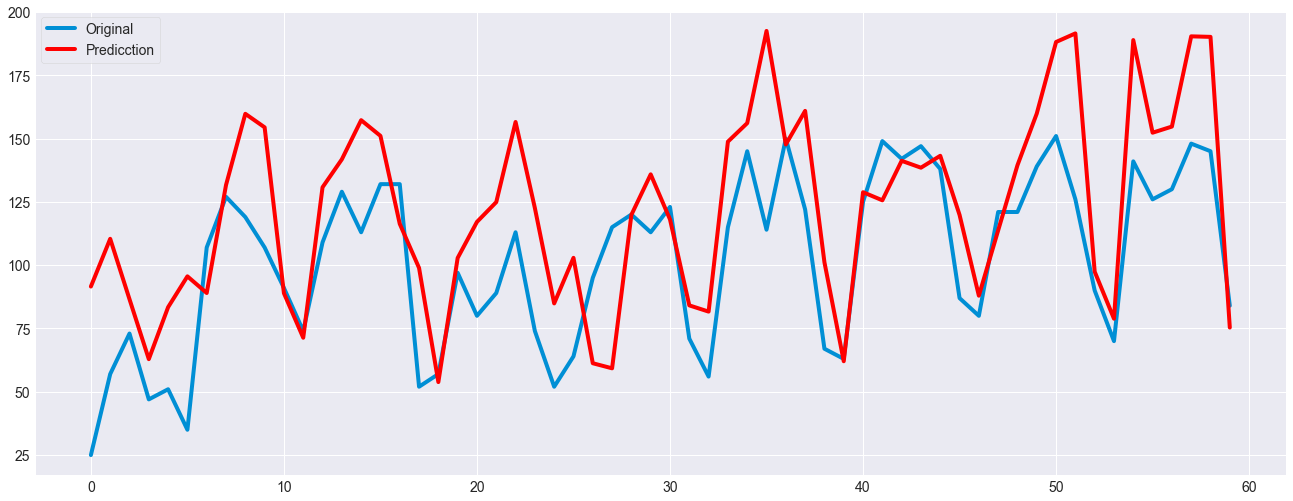

In [421]:
bicimad_est = bicimad[bicimad['ESTACION'] == 163]
    
X_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
X_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')].drop(['DEMANDA',"FECHA",'ESTACION'], axis=1)
y_train = bicimad_est.loc[(bicimad["FECHA"] <= '2019-12-31 23:59:00')]['DEMANDA']
y_test = bicimad_est.loc[(bicimad["FECHA"] >= '2020-01-01 00:00:00')]['DEMANDA']


model = GradientBoostingRegressor(random_state=seed,
                                  learning_rate= 0.03, 
                                  max_depth= 300, 
                                  n_estimators= 900, 
                                  subsample= 0.06)

resultado = model.fit(X_train, y_train)
predictions = resultado.predict(X_test)
score =model.score(X_test, y_test, sample_weight=None)


print(score)
plt.figure(figsize=(20,8))
plt.plot(y_test.values, label='Original')
plt.plot(predictions, color='red', label='Predicction')
plt.legend()

feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances[:30]

In [420]:
model = GradientBoostingRegressor(random_state=seed,
                                  learning_rate= 0.03, 
                                  max_depth= 300, 
                                  n_estimators= 900, 
                                  subsample= 0.06)

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123567)
cv_scores = cross_validate(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2'),
                cv        = cv,
                return_train_score = True
            )

cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_score,train_score
0,0.388686,0.012531,0.575545,0.900455
1,0.365096,0.011870,0.694353,0.887990
2,0.366590,0.011533,0.429054,0.917064
3,0.371953,0.011704,0.637021,0.898398
4,0.366379,0.011891,0.471393,0.896328
5,0.368072,0.012085,0.590284,0.899854
6,0.366879,0.012153,0.499426,0.912132
7,0.369331,0.011708,0.617942,0.892572
8,0.367092,0.011962,0.456411,0.906698
9,0.367041,0.012023,0.650096,0.879911
